In [9]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
test_image = cv2.imread('/content/test_image.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
test_image = cv2.resize(test_image, (256, 256))

In [3]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis=0),
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [4]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], 256, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


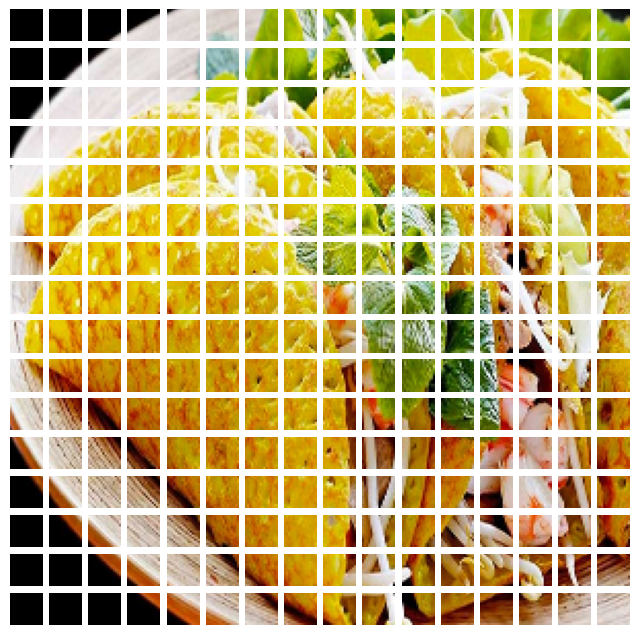

In [5]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

# plt.figure(figsize=(8, 8))
# k = 0
# for i in range(16):
#   for j in range(16):
#     ax = plt.subplot(16, 16, k + 1)
#     plt.imshow(tf.reshape(patches[0, i, j,:], (16, 16, 3)))
#     plt.axis("off")
#     k += 1

In [10]:
class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = tf.keras.layers.Dense(HIDDEN_SIZE)
    self.positional_embedding = tf.keras.layers.Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, 16, 16, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

In [11]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = tf.keras.layers.LayerNormalization()
    self.layer_norm_2 = tf.keras.layers.LayerNormalization()

    self.multi_head_att = tf.keras.layers.MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = tf.keras.layers.Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = tf.keras.layers.Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = tf.keras.layers.Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = tf.keras.layers.Add()([output, x_1])

    return output

In [13]:
class ViT(tf.keras.models.Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS, NUM_CLASSES):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = tf.keras.layers.Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = tf.keras.layers.Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = tf.keras.layers.Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [14]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128, NUM_CLASSES=10)
vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.16524161, 0.13541403, 0.13339734, 0.0748564 , 0.07720891,
        0.07143775, 0.11759713, 0.0904953 , 0.06147822, 0.07287336],
       [0.16524158, 0.13541408, 0.13339733, 0.07485642, 0.07720891,
        0.07143772, 0.11759712, 0.09049525, 0.06147822, 0.07287335]],
      dtype=float32)>

In [15]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_5 (Dense)             multiple                  25165952  
                                                                 
 dense_6 (Dense)             multiple                  16512     
                                                